In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

from tqdm.notebook import tqdm, trange
from numba import njit, prange

np.set_printoptions(suppress=True)

In [18]:
N = 100
capacity = 5

In [19]:
a, b, m = 0.1, 0.02, 2.5 # parameters for the failure rate function
theta = 1 # degradation rate
arrival_rate = 10
max_k = 50 # maximum number of increments of time-based degradation

max_degradation = 50
holding_cost = 5 # per-time holding cost
replacement_cost = 11 # replacement const
failure_cost = 5 # failure cost
u = 10 # utility constant

def failure_rate(d):
    """
    Calculate the failure rate of the machine based on its current degradation level.
    The failure rate is modeled as a quadratic function of the degradation level.
    The parameters a, b, and m are constants that define the shape of the function.

    Args:
        d (float): Current degradation level

    Returns:
        float: Failure rate
    """
    return a + b(d - m) ** 2

def failure_probability(d, x, max_degradation=max_degradation):
    """
    Calculate the probability of failure based on the current degradation level and an increment in degradation level.

    Args:
        d (float): Current degradation level
        x (float): Increment in degradation level
        max_degradation (float): Maximum degradation level

    Returns:
        p: Probability of failure
    """
    return 1 - np.exp(
        -(
            a*x + b*x*(3*m**2 - 3*m*(x+2*d) + x**2 + 3*x*d + 3*d**2)/3   
        )
    )

def rounded_exponential_pmf(lambda_, max_k=500):
    x_vals = np.arange(1, max_k + 1) / 100  # 0.01 to 5.00 (or adjust as needed)
    lower_bounds = np.where(x_vals > 0, x_vals - 0.005, 0)
    upper_bounds = x_vals + 0.005
    cdf = lambda x: 1 - np.exp(-lambda_ * x)
    pmf = cdf(upper_bounds) - cdf(lower_bounds)
    return x_vals, pmf

def get_random_increment_x():
    """
    Sample a random increment x from a discrete uniform distribution.

    Returns:
        x: Random increment
    """
    return np.random.randint(N) / N

def simulate_machine():
    usage = 0
    time_until_failure = 0
    
    while True:
        x = get_random_increment_x()
        
        p = np.random.random()
        if p <= failure_probability(usage, x):
            # machine failure
            return usage, time_until_failure
        usage += x
        time_until_failure += 1


In [20]:
usages, tufs = [], []

for _ in range(10000):
    usage, time_until_failure = simulate_machine()
    usages.append(usage)
    tufs.append(time_until_failure)
    
usages = np.array(usages)
tufs = np.array(tufs)

In [21]:
print("Mean degradation at failure:", usages.mean())
print("Mean number of rentals until failure:", tufs.mean())

Mean degradation at failure: 4.3771770000000005
Mean number of rentals until failure: 9.1661


In [22]:
precision = 2

In [23]:
contexts = np.arange(0.2, 1, 1 / N).round(precision)
states = np.arange(0, max_degradation, 1/N).round(precision)

RENT, SHUTDOWN, REPLACE = 0, 1, 2

actions = [
    RENT,
    SHUTDOWN,
    REPLACE
]

n_states = len(states)
n_contexts = len(contexts)
n_actions = len(actions)

P = np.zeros((n_states, n_contexts, n_actions, n_states), dtype=np.float32)
R = np.zeros((n_states, n_contexts, n_actions, n_states), dtype=np.float32)

In [24]:
failure_probability(49.80, 0.20)

0.9998774575838142

In [25]:
# time-based degradation
tbd_x, tbd_pmf = rounded_exponential_pmf(arrival_rate, max_k=max_k)
tbd_pmf = tbd_pmf / tbd_pmf.sum()

In [26]:
d_inds = np.arange(1, max_k + 1)

# initialize the transition and reward matrices

for s_ind, s in tqdm(enumerate(states)):
    for a_ind, a in enumerate(actions):
        if a == SHUTDOWN:
            if s_ind == n_states - 1:
                # machine breaks down on its own
                P[s_ind, :, a_ind, 0] = 1
                R[s_ind, :, a_ind, 0] = -replacement_cost - holding_cost
                
                # # # machine can't fail but still incurs holding cost
                # P[s_ind, :, a_ind, s_ind] = 1
                # R[s_ind, :, a_ind, s_ind] = -holding_cost
            
            elif s_ind + max_k < n_states:
                # machine undergoes time-based degradation, 
                # and can fail due to time-based degradation.
                
                failure_probs = failure_probability(s, tbd_x)
                failure_prob = (tbd_pmf * failure_probs).sum()

                # surviving time-based degradation
                P[s_ind, :, a_ind, s_ind+d_inds] = np.tile(
                    tbd_pmf * (1- failure_probs),
                    (n_contexts, 1)
                ).T
                R[s_ind, :, a_ind, s_ind+d_inds] = -holding_cost
                
                # failing due to time-based degradation
                P[s_ind, :, a_ind, 0] = failure_prob
                R[s_ind, :, a_ind, 0] = -replacement_cost - holding_cost
                
            else:
                # time-degradataion can reach the maximum degradation level
                # probabilities of transitions that lead to the maximum degradation level or above
                # are summed up and assigned to probability of transition to the maximum degradation level
                
                split_index = np.where(s_ind + d_inds == n_states-1)[0][0]
                tbd_pmf_before = tbd_pmf[:split_index]
                tbd_pmf_after_sum = tbd_pmf[split_index:].sum()
                tbd_pmf_new = np.append(tbd_pmf_before, tbd_pmf_after_sum)

                failure_probs = failure_probability(s, tbd_x[:len(tbd_pmf_new)])
                failure_prob = (tbd_pmf_new * failure_probs).sum()

                # surviving time-based degradation
                P[s_ind, :, a_ind, -len(tbd_pmf_new):] = np.tile(
                    tbd_pmf_new * (1- failure_probs),
                    (n_contexts, 1)
                )
                R[s_ind, :, a_ind, -len(tbd_pmf_new):] = -holding_cost
                
                # failing due to time-based degradation
                P[s_ind, :, a_ind, 0] = failure_prob
                R[s_ind, :, a_ind, 0] = -replacement_cost - holding_cost

        elif a == REPLACE:
            # machine is replaced and the degradation level is reset to 0
            P[s_ind, :, a_ind, 0] = 1
            R[s_ind, :, a_ind, 0] = -replacement_cost
            
        elif a == RENT:
            for x_ind, x in enumerate(contexts):
                ns = round(s + x, precision)
                ind_ns = round(ns * 100) if ns <= states[-1] else -1
                
                # machine is rented out and fails
                P[s_ind, x_ind, a_ind, 0] = failure_probability(s, x)
                R[s_ind, x_ind, a_ind, 0] = u * x - replacement_cost - failure_cost
                
                # machine is rented out and survives
                P[s_ind, x_ind, a_ind, ind_ns] = 1 - P[s_ind, x_ind, a_ind, 0]
                R[s_ind, x_ind, a_ind, ind_ns] = u * x                
                
            

0it [00:00, ?it/s]

In [ ]:
s, x = 12.5, .65
k = 3

s_ind = round(s * 100)
x_ind = round(x*100 - 20)
ns = round(s + x, 2)
ns_ind = min(
    round(ns * 100),
    n_states-1
)

print(f"Failure Probability: {P[s_ind, x_ind, RENT, 0]}")
print(f"Reward, Shutdown-Survival: {R[s_ind, x_ind, SHUTDOWN, s_ind+1]}\nReward, Shutdown-Failure: {R[s_ind, x_ind, SHUTDOWN, 0]}")
print(f"\nReward, Rent-Survival: {R[s_ind, x_ind, RENT, ns_ind]}\nReward, Rent-Failure: {R[s_ind, x_ind, RENT, 0]}")
print(f"Reward, Replace: {R[s_ind, x_ind, REPLACE, 0]}")

print("\nTop 3 Transition Probabilities (RENT):")

arr = P[s_ind, x_ind, RENT]
# k = min(k, len(arr))
top_k_indices = np.argpartition(arr, -k)[-k:]
top_k_indices = top_k_indices[np.argsort(-arr[top_k_indices])]
top_k_values = arr[top_k_indices]
result = list(zip(top_k_indices, top_k_values))
result = [i for i in result if i[1] > 0]
for ns, prob in result:
    print(f"\tNext state: {states[ns]}, Probability: {round(100 * prob, 2)}")
    
print("\nTop 3 Transition Probabilities (SHUTDOWN):")

arr = P[s_ind, x_ind, SHUTDOWN]
# k = min(k, len(arr))
top_k_indices = np.argpartition(arr, -k)[-k:]
top_k_indices = top_k_indices[np.argsort(-arr[top_k_indices])]
top_k_values = arr[top_k_indices]
result = list(zip(top_k_indices, top_k_values))
result = [i for i in result if i[1] > 0]
for ns, prob in result:
    print(f"\tNext state: {states[ns]}, Probability: {round(100 * prob, 2)}")
    
print("\nTop 3 Transition Probabilities (REPLACE):")

arr = P[s_ind, x_ind, REPLACE]
# k = min(k, len(arr))
top_k_indices = np.argpartition(arr, -k)[-k:]
top_k_indices = top_k_indices[np.argsort(-arr[top_k_indices])]
top_k_values = arr[top_k_indices]
result = list(zip(top_k_indices, top_k_values))
result = [i for i in result if i[1] > 0]
for ns, prob in result:
    print(f"\tNext state: {states[ns]}, Probability: {round(100 * prob, 2)}")

Failure Probability: 0.7500091195106506
Reward, Shutdown-Survival: -5.0
Reward, Shutdown-Failure: -16.0

Reward, Rent-Survival: 6.5
Reward, Rent-Failure: -9.5
Reward, Replace: -11.0

Top 3 Transition Probabilities (RENT):
	Next state: 0.0, Probability: 75.0
	Next state: 13.15, Probability: 25.0

Top 3 Transition Probabilities (SHUTDOWN):
	Next state: 0.0, Probability: 24.03
	Next state: 12.51, Probability: 9.3
	Next state: 12.52, Probability: 8.16

Top 3 Transition Probabilities (REPLACE):
	Next state: 0.0, Probability: 100.0


In [28]:
def value_iteration(P, R, V=None, policy=None, gamma=1.0, theta=1e-8, max_iter=10000):
    """
    Perform value iteration for an MDP to find the optimal policy and value function.
    - N+1 states (0..N), where N is terminal
    - M contexts (0..M-1)
    - 2 actions (0, 1)

    Parameters:
        P (numpy.ndarray): Transition probabilities
            4D array of shape (n_states, n_contexts, n_actions, n_states)
        R (numpy.ndarray): Rewards
            4D array of shape (n_states, n_contexts, n_actions, n_states)
        gamma (float): Discount factor
        theta (float): Threshold for convergence
        max_iter (int): Maximum number of iterations
        V (numpy.ndarray): Initial value function (optional)
            If None, it will be initialized to zeros.
        policy (numpy.ndarray): Initial policy (optional)
            If None, it will be initialized to zeros.

    Returns:
        V (numpy.ndarray): Optimal value function
        policy (numpy.ndarray): Optimal policy
    """
    n_states, n_contexts, n_actions = P.shape[0], P.shape[1], P.shape[2]
    
    # V and policy must be provided together or not at all
    if V is not None and policy is not None:
        assert V.shape == (n_states, n_contexts), "V must have shape (n_states, n_contexts)"
        assert policy.shape == (n_states, n_contexts), "policy must have shape (n_states, n_contexts)"
    elif V is not None:
        assert V.shape == (n_states, n_contexts), "V must have shape (n_states, n_contexts)"
        policy = np.zeros((n_states, n_contexts), dtype=int)
    elif policy is not None:
        assert policy.shape == (n_states, n_contexts), "policy must have shape (n_states, n_contexts)"
        V = np.zeros((n_states, n_contexts))
    else:
        # If neither V nor policy is provided, initialize both
        V = np.zeros((n_states, n_contexts))
        policy = np.zeros((n_states, n_contexts), dtype=int)

    for _ in trange(max_iter):
        delta = 0.0
        V_prev = V.copy()
        
        for s in range(n_states):
            for x in range(n_contexts):
                # compute the q-value for each action
                # Q(a) = sum_{s_next} P[s,x,a,s_next] * (R[s,x,a,s_next] + gamma * V_prev[s_next,x])
                
                Q_values = np.zeros(n_actions)
                for a in range(n_actions):
                    expected_reward = np.sum(P[s, x, a, :] * R[s, x, a, :])
                    expected_future = P[s, x, a, :] @ V_prev.mean(avis=1)
                    Q_values[a] = expected_reward + gamma * expected_future
                    
                # Best action and best value
                best_action = np.argmax(Q_values)
                best_value = Q_values[best_action]
                V[s, x] = best_value
                policy[s, x] = best_action
                delta = max(delta, abs(V[s, x] - V_prev[s, x]))
        # Check for convergence
        if delta < theta:
            break
        
    return V, policy

# V, policy = value_iteration(P, R, V=V, policy=policy, gamma=1.0, theta=1e-6, max_iter=1000)

In [29]:
@njit(parallel=True)
def value_iteration_numba(P, R, gamma, theta, max_iter):
    n_states, n_contexts, n_actions, _ = P.shape
    V = np.zeros((n_states, n_contexts))
    policy = np.zeros((n_states, n_contexts), dtype=np.int64)

    for _ in range(max_iter):
        delta = 0.0
        V_prev = V.copy()

        V_prev_mean = np.zeros(n_states)
        for s in range(n_states):
            for x in range(n_contexts):
                V_prev_mean[s] += V_prev[s, x]
            V_prev_mean[s] /= n_contexts
        
        # We can parallelize over s and x, but must do a 2D loop
        for s in prange(n_states):
            for x in range(n_contexts):
                # compute Q-values
                Q_values = np.zeros(n_actions)
                for a_ind in range(n_actions):
                    reward = 0
                    future = 0
                    for s_next in range(n_states):
                        reward += P[s, x, a_ind, s_next] * R[s, x, a_ind, s_next]
                        future += P[s, x, a_ind, s_next] * V_prev_mean[s_next]

                    Q_values[a_ind] = reward + gamma * future                        
                        
                best_a = np.argmax(Q_values)
                best_v = Q_values[best_a]
                policy[s, x] = best_a
                V[s, x] = best_v
                diff = abs(best_v - V_prev[s,x])
                
                if diff > delta:
                    delta = diff
        if delta < theta:
            break

    return V, policy


In [30]:
V, policy = value_iteration_numba(
    P, R,
    gamma=1, theta=1e-8, max_iter=10000
)

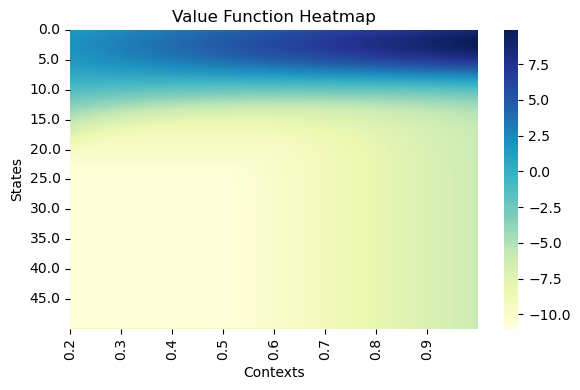

In [ ]:
# plot the value function as heatmap

plt.figure(figsize=(6, 4))
sns.heatmap(V, cmap="YlGnBu", cbar=True, xticklabels=contexts, yticklabels=states)
plt.title("Value Function Heatmap")
plt.xlabel("Contexts")
plt.ylabel("States")

# set x ticks to be multiples of 2
# set y ticks to be multiples of 0.1
plt.xticks(ticks=np.arange(0, len(contexts), 10), labels=contexts[::10])
plt.yticks(ticks=np.arange(0, len(states), 500), labels=states[::500])
plt.grid(False)
plt.tight_layout()

plt.savefig("figs/value_function_heatmap.png", dpi=300)
plt.show()


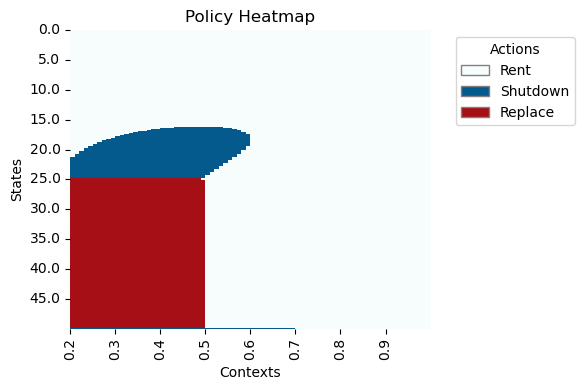

: 

In [ ]:
# plot the policy as heatmap
# Assume your policy array contains only values 0, 1, or 2
# Mapping: 0 -> "A", 1 -> "B", 2 -> "C"
labels = ["Rent", "Shutdown", "Replace"]
colors = ["#f7fcfd", "#045a8d", "#a50f15"]  # example colors for A, B, C

# Define colormap and normalization
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3]  # one more than the max value
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 4))
sns.heatmap(policy, cmap=cmap, norm=norm, cbar=False,
            xticklabels=contexts, yticklabels=states)

plt.title("Policy Heatmap")
plt.xlabel("Contexts")
plt.ylabel("States")

plt.xticks(ticks=np.arange(0, len(contexts), 10), labels=contexts[::10])
plt.yticks(ticks=np.arange(0, len(states), 500), labels=states[::500])
plt.grid(False)

# Custom legend
legend_elements = [Patch(facecolor=colors[i], edgecolor='gray', label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_elements, title="Actions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("figs/policy_heatmap.png", dpi=300)

plt.show()